# Preproces of the data

In [1]:
import numpy as np
import nibabel.processing as nibp
import os
import nibabel as nib
import math
import random
import sklearn.preprocessing
import matplotlib.pyplot as plt
from numpy import random as rd
from sklearn.metrics import mean_squared_error
from torch.utils.data import random_split

In [2]:
class Scaler():
    # used for normalization
    def __init__(self,inputs):
        self.data = inputs
        self.mean = np.mean(inputs,axis=1)
        self.std = np.std(inputs, axis=1)
        self.vox, self.time = inputs.shape
    def transform(self,inputs):
        self.mean = np.reshape(self.mean,(self.vox,1))
        self.m_large = np.repeat(self.mean,self.time,axis=1)
        self.std = np.reshape(self.std,(self.vox,1))
        self.s_large = np.repeat(self.std,self.time,axis=1)
        return np.divide(inputs-self.m_large,self.s_large)
    def inverse_transform(self,outputs):
        return np.multiply(outputs,self.s_large)+self.m_large

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
obs_list = np.loadtxt('drive/MyDrive/dataset/obs_list.csv',dtype=float,delimiter=',',usecols=range(156))
gt_list = np.loadtxt('drive/MyDrive/dataset/gt_list.csv',dtype=float,delimiter=',',usecols=range(156))
noi_list = np.loadtxt('drive/MyDrive/dataset/noi_list.csv',dtype=float,delimiter=',',usecols=range(156))

In [ ]:
print(obs_list.shape)

(15479, 156)


Text(0.5, 1.0, 'noise, not the noise added to the signal')

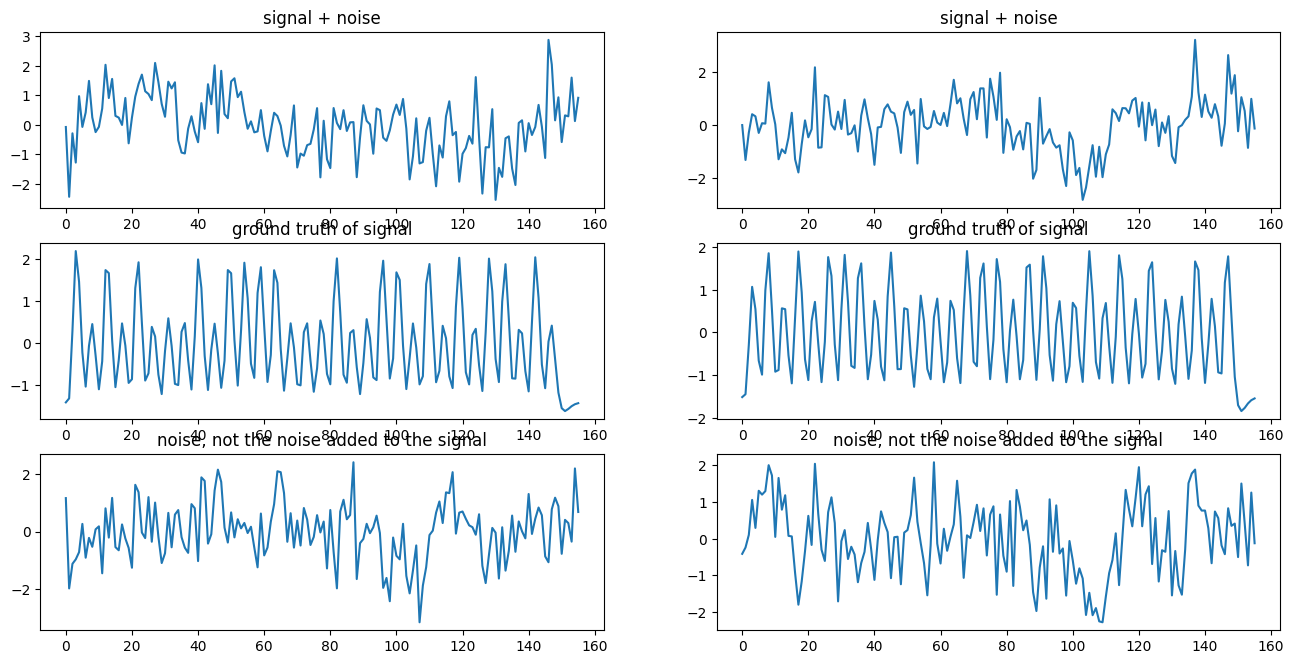

In [ ]:
x = [i for i in range(noi_list.shape[1])]
plt.figure(figsize = (16,16))
plt.subplot(6,2,1)
plt.plot(x,obs_list[900],'-')
plt.title('signal + noise')
plt.subplot(6,2,2)
plt.plot(x,obs_list[24],'-')
plt.title('signal + noise')
plt.subplot(6,2,3)
plt.plot(x,gt_list[900],'-')
plt.title('ground truth of signal')
plt.subplot(6,2,4)
plt.plot(x,gt_list[24],'-')
plt.title('ground truth of signal')
plt.subplot(6,2,5)
plt.plot(x,noi_list[900],'-')
plt.title('noise, not the noise added to the signal')
plt.subplot(6,2,6)
plt.plot(x,noi_list[24],'-')
plt.title('noise, not the noise added to the signal')

# DataLoader

In [5]:
import torch
class PathDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y, Z):
    self.obs = X
    self.gt = Y
    self.noi = Z

  def __len__(self):
    return self.gt.shape[0]

  def __getitem__(self, index):
    observation = self.obs[index][0:156]
    ground_truth = self.gt[index][0:156]
    noise = self.noi[random.randrange(self.noi.shape[0])][0:156] # shuffle the noise
    s = 2*rd.beta(4,4,1)
    noise_aug = s*noise

    return observation, ground_truth, noise_aug

In [6]:
# initiate dataset in pytorch
inputs_all = PathDataset(obs_list,gt_list,noi_list)
generator = torch.Generator().manual_seed(42)
train_inputs, val_inputs, test_inputs = random_split(inputs_all, [0.7, 0.15, 0.15], generator=generator)

In [7]:
# dataloading
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=64,
                                             shuffle=True, num_workers=1)
val_in = torch.utils.data.DataLoader(val_inputs, batch_size=len(val_inputs),
                                             shuffle=False, num_workers=1)
test_in = torch.utils.data.DataLoader(test_inputs, batch_size=len(test_inputs),
                                             shuffle=False, num_workers=1)

# cVAE model

In [8]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

In [9]:
import torch
from torch import nn
from torch.nn import functional as F

class cVAE(nn.Module):


    def __init__(self,in_channels: int,latent_dim: int,hidden_dims: List = None) -> None:
        super(cVAE, self).__init__()

        self.latent_dim = latent_dim
        self.in_channels = in_channels

        modules_z = []
        if hidden_dims is None:
            hidden_dims = [64, 128, 256, 256]

        # Build Encoder
        for h_dim in hidden_dims:
            modules_z.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_z = nn.Sequential(*modules_z)
        self.fc_mu_z = nn.Linear(hidden_dims[-1]*10, latent_dim)
        self.fc_var_z = nn.Linear(hidden_dims[-1]*10, latent_dim)

        modules_s = []
        in_channels = self.in_channels
        for h_dim in hidden_dims:
            modules_s.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_s = nn.Sequential(*modules_s)
        self.fc_mu_s = nn.Linear(hidden_dims[-1]*10, latent_dim)
        self.fc_var_s = nn.Linear(hidden_dims[-1]*10, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(2*latent_dim, hidden_dims[-1] * 10)

        hidden_dims.reverse()


        for i in range(len(hidden_dims) - 1):
            if i//2==0:
                modules.append(
                    nn.Sequential(
                        nn.ConvTranspose1d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                        nn.BatchNorm1d(hidden_dims[i + 1]),
                        nn.LeakyReLU())
                )
            else:
                modules.append(
                    nn.Sequential(
                        nn.ConvTranspose1d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=0),
                        nn.BatchNorm1d(hidden_dims[i + 1]),
                        nn.LeakyReLU())
                )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=2,
                                               output_padding=1),
                            nn.BatchNorm1d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv1d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1))
           #out_channels

    def encode_z(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        """
        result = self.encoder_z(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_z(result)
        log_var = self.fc_var_z(result)

        return [mu, log_var]

    def encode_s(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        """
        result = self.encoder_s(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_s(result)
        log_var = self.fc_var_s(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the sequence space.
        """
        result = self.decoder_input(z)
        result = result.view(-1,256,10)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward_tg(self, input: Tensor) -> List[Tensor]:
        """
        Forward the input to both encoder s and z and concatenate them
        """
        tg_mu_z, tg_log_var_z = self.encode_z(input)
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        output = self.decode(torch.cat((tg_z, tg_s),1))
        return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]

    def forward_bg(self, input: Tensor) -> List[Tensor]:
        """
        Forward the input to both encoder s only and make another half of latent space 0s
        """
        bg_mu_s, bg_log_var_s = self.encode_s(input)
        bg_s = self.reparameterize(bg_mu_s, bg_log_var_s)
        zeros = torch.zeros_like(bg_s)
        output = self.decode(torch.cat((zeros, bg_s),1))
        return  [output, input, bg_mu_s, bg_log_var_s]

    def forward_fg(self, input: Tensor) -> List[Tensor]:
        """
        Forward the input to both encoder z only and make another half of latent space 0s
        """
        fg_mu_z, fg_log_var_z = self.encode_z(input)
        tg_z = self.reparameterize(fg_mu_z, fg_log_var_z)
        zeros = torch.zeros_like(tg_z)
        output = self.decode(torch.cat((tg_z, zeros),1))
        return  [output, input, fg_mu_z, fg_log_var_z]

    def loss_function(self,
                      *args,
                      ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        """
        beta = 0.00001 # ratio of kl loss compared to reconstruction loss
        gamma = 1

        recons_tg = args[0]
        input_tg = args[1]
        tg_mu_z = args[2]
        tg_log_var_z = args[3]
        tg_mu_s = args[4]
        tg_log_var_s = args[5]
        tg_z = args[6]
        tg_s = args[7]
        recons_bg = args[8]
        input_bg = args[9]
        bg_mu_s = args[10]
        bg_log_var_s = args[11]

        recons_loss = F.mse_loss(recons_tg, input_tg)
        recons_loss += F.mse_loss(recons_bg, input_bg)


        kld_loss = 1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp()
        kld_loss += 1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp()
        kld_loss += 1 + bg_log_var_s - bg_mu_s ** 2 - bg_log_var_s.exp()
        kld_loss = torch.mean(-0.5 * torch.sum(kld_loss, dim = 1), dim = 0)

        loss = torch.mean(recons_loss + beta*kld_loss)
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD': kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        sequence space map.
        """
        z = torch.randn(num_samples,
                        self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        """
        return self.forward_fg(x)[0]

In [10]:
# initiate the model with intended latent space size
model = cVAE(1,8)

In [11]:
# optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
# model

In [ ]:
print(len(train_in))
print(len(val_in))
print(len(test_in))

170
1
1


# Training the model

In [12]:
def r_squared_list(x,y):
  # calculate the R-squared between each pair of sequences in two lists of sequences
  x_mean = np.repeat(np.reshape(x.mean(axis=1),(x.shape[0],1)),x.shape[1],axis=1)
  y_mean = np.repeat(np.reshape(y.mean(axis=1),(y.shape[0],1)),y.shape[1],axis=1)
  cov = (x-x_mean)*(y-y_mean)
  r_row = cov.sum(axis=1)/(x.std(axis=1)*y.std(axis=1)*x.shape[1])
  return np.square(r_row)

In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
batch_size = 64
epoch_num = 200
train_loss_L = []
train_recons_L = []
train_KLD_L = []
val_loss_L = []
val_recons_L = []
val_KLD_L = []
test_correlation_L = []
test_loss_n_L = []
test_percentile_L = []
early_stopper = EarlyStopper(patience=10, min_delta=0.001)

for epoch in range(epoch_num):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, epoch_num-1))
    print('-' * 10)

    train_loss = 0.0
    train_reconstruction_loss = 0.0
    train_KLD = 0.0
    val_loss = 0.0
    val_reconstruction_loss = 0.0
    val_KLD = 0.0

    # Iterate over data.
    dataloader_iter_in = iter(train_in)
    for i in range(len(train_in)):
        inputs_gm,inputs_gt,inputs_cf = next(dataloader_iter_in)

        inputs_gm = inputs_gm.unsqueeze(1).float().to(device)
        inputs_cf = inputs_cf.unsqueeze(1).float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # encoder + decoder
        [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(inputs_gm)
        [outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(inputs_cf)
        outputs = torch.concat((outputs_gm,outputs_cf),1)
        loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x, outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s)
        # backward + optimize
        loss['loss'].backward()
        optimizer.step()
        # print statistics
        train_loss += loss['loss']
        train_reconstruction_loss += loss['Reconstruction_Loss']
        train_KLD += loss['KLD']
    # validation
    with torch.no_grad():
        val_gm, val_gt, val_cf = next(iter(val_in))
        val_gm = val_gm.unsqueeze(1).float().to(device)
        val_cf = val_cf.unsqueeze(1).float().to(device)
        #[output_val, input_val, fg_mu_z, fg_log_var_z] = model.forward_fg(val_gm)
        #loss_val = model.loss_function_val(output_val, input_val, fg_mu_z, fg_log_var_z)
        [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(val_gm)
        [outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(val_cf)
        loss_val = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x, outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s)
        if early_stopper.early_stop(loss_val['loss']):
            break

    epoch_train_loss = train_loss / (len(train_in)*2)
    epoch_train_reconstruction_loss = train_reconstruction_loss / (len(train_in)*2)
    epoch_train_KLD = train_KLD / (len(train_in)*2)
    epoch_val_loss = loss_val['loss']
    epoch_val_reconstruction_loss= loss_val['Reconstruction_Loss']
    epoch_val_KLD = loss_val['KLD']
    print('Training Loss: {:.4f} Training Reconstruction Loss: {:.4f} Training KLD {:.4f}'.format(epoch_train_loss, epoch_train_reconstruction_loss, epoch_train_KLD))
    print('Val Loss: {:.4f} Val Reconstruction Loss: {:.4f} Val KLD {:.4f})'.format(epoch_val_loss,epoch_val_reconstruction_loss,epoch_val_KLD))
    print('')
    print()
    train_loss_L.append(epoch_train_loss)
    train_recons_L.append(epoch_train_reconstruction_loss)
    train_KLD_L.append(epoch_train_KLD)
    val_loss_L.append(epoch_val_loss)
    val_recons_L.append(epoch_val_reconstruction_loss)
    val_KLD_L.append(epoch_val_KLD)

print('Finished Training')

test_gm, test_gt, test_cf = next(iter(test_in))
test_gm = test_gm.unsqueeze(1).float().to(device)
test_gt = test_gt.unsqueeze(1).float().to(device)
test_cf = test_cf.unsqueeze(1).float().to(device)
[output_test, input_test, fg_mu_z, fg_log_var_z] = model.forward_fg(test_gm)
# loss_test = model.loss_function_val(output_test, input_test, fg_mu_z, fg_log_var_z)
# print('Test Loss: {:.4f} Test Reconstruction Loss: {:.4f} Test KLD {:.4f})'.format(loss_test['val_loss'],loss_test['val_recons_Loss'],loss_test['val_KLD']))

Epoch 0/199
----------
Training Loss: 0.5083 Training Reconstruction Loss: 0.5074 Training KLD 94.4135
Val Loss: 0.8439 Val Reconstruction Loss: 0.8418 Val KLD 208.8297)


Epoch 1/199
----------
Training Loss: 0.4129 Training Reconstruction Loss: 0.4118 Training KLD 109.1543
Val Loss: 0.8063 Val Reconstruction Loss: 0.8040 Val KLD 221.4841)


Epoch 2/199
----------
Training Loss: 0.3967 Training Reconstruction Loss: 0.3955 Training KLD 112.8854
Val Loss: 0.7988 Val Reconstruction Loss: 0.7965 Val KLD 230.1133)


Epoch 3/199
----------
Training Loss: 0.3921 Training Reconstruction Loss: 0.3909 Training KLD 114.2447
Val Loss: 0.7889 Val Reconstruction Loss: 0.7867 Val KLD 227.8938)


Epoch 4/199
----------
Training Loss: 0.3866 Training Reconstruction Loss: 0.3854 Training KLD 115.2453
Val Loss: 0.7774 Val Reconstruction Loss: 0.7751 Val KLD 231.3350)


Epoch 5/199
----------
Training Loss: 0.3844 Training Reconstruction Loss: 0.3832 Training KLD 115.9228
Val Loss: 0.7694 Val Reconstruct

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/dataset/simulations/model_realistic_run3')

In [15]:
output_scale = Scaler(output_test.squeeze().cpu().detach().numpy())
outputs_test_n = output_scale.transform(output_test.squeeze().cpu().detach().numpy())
final_test_r_squared_list = r_squared_list(test_gt.squeeze().cpu().detach().numpy(),outputs_test_n)
final_test_mean = final_test_r_squared_list.mean()
final_test_percentile= (np.percentile(final_test_r_squared_list,5), np.percentile(final_test_r_squared_list,95))

In [16]:
print(final_test_mean)
print(final_test_percentile)

0.592826
(0.343624085187912, 0.793073832988739)


# Error and Visualization

In [24]:
train_loss_L2 = [item.detach().cpu().numpy() for item in train_loss_L]
train_loss_L2 = np.array(train_loss_L2)
train_recons_L2 = [item.detach().cpu().numpy() for item in train_recons_L]
train_recons_L2 = np.array(train_recons_L2)
train_KLD_L2 = [item.detach().cpu().numpy() for item in train_KLD_L]
train_KLD_L2 = np.array(train_KLD_L2)

In [25]:
val_loss_L2 = [item.detach().cpu().numpy() for item in val_loss_L]
val_loss_L2 = np.array(val_loss_L2)
val_recons_L2 = [item.detach().cpu().numpy() for item in val_recons_L]
val_recons_L2 = np.array(val_recons_L2)
val_KLD_L2 = [item.detach().cpu().numpy() for item in val_KLD_L]
val_KLD_L2 = np.array(val_KLD_L2)

<ipython-input-26-7606e8d2f462>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


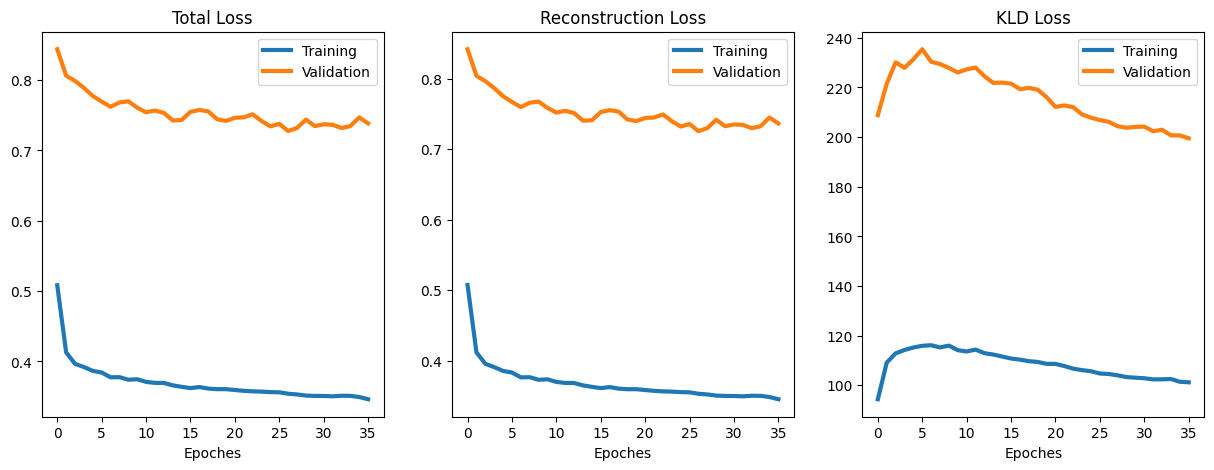

In [26]:
num_list = [i for i in range(len(train_loss_L2))]
fig,ax = plt.subplots(figsize =(15,5))
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.subplot(1,3,1)
plt.plot(num_list,train_loss_L2, '-',linewidth=3, label='Training')
plt.title('Total Loss')
plt.xlabel('Epoches')
plt.plot(num_list,val_loss_L2, '-',linewidth=3,label='Validation')
plt.legend()
plt.subplot(1,3,2)
plt.plot(num_list,train_recons_L2, '-',linewidth=3, label='Training')
plt.title('Reconstruction Loss')
plt.xlabel('Epoches')
plt.plot(num_list,val_recons_L2, '-',linewidth=3,label='Validation')
plt.legend()
plt.subplot(1,3,3)
plt.plot(num_list,train_KLD_L2, '-',linewidth=3, label='Training')
plt.title('KLD Loss')
plt.xlabel('Epoches')
plt.plot(num_list,val_KLD_L2, '-',linewidth=3,label='Validation')
plt.legend()

# CompCorr

In [17]:
dataloader_iter_in = iter(train_in)
train_gm,train_gt,train_cf = next(dataloader_iter_in)
for i in range(1,len(train_in)):
    train_gm_new,train_gt_new,train_cf_new = next(dataloader_iter_in)
    train_gm = np.concatenate((train_gm,train_gm_new),axis=0)
    train_cf = np.concatenate((train_cf,train_cf_new),axis=0)
print(train_gm.shape)
print(train_cf.shape)

(10836, 156)
(10836, 156)


In [18]:
test_gm, test_gt,test_cf = next(iter(test_in))
test_gm = test_gm.numpy()
test_gt = test_gt.numpy()
test_cf = test_cf.numpy()

In [19]:
from sklearn.decomposition import PCA
from sklearn import linear_model

# PCA likes the time dimension as first. Let's transpose our data.
train_gm_t = np.transpose(train_gm)
train_cf_t = np.transpose(train_cf)
test_gm_t = np.transpose(test_gm)
test_cf_t = np.transpose(test_cf)
# Fit PCA and extract PC timecourses
pca = PCA(n_components = 5)
pca.fit(train_cf_t)
#
confounds_pc = pca.fit_transform(test_cf_t)
confounds_pc.shape

(156, 5)

In [20]:
# linear regression on each voxel: PCs -> voxel pattern
linear = linear_model.LinearRegression()
linear.fit(confounds_pc, test_gm_t)

# predict the activity of each voxel for this run
predict = linear.predict(confounds_pc)
func_denoised = test_gm_t - predict # t x v
func_denoised = np.transpose(func_denoised) # v x t
func_denoised.shape

(2321, 156)

In [21]:
compcor_r_squared_list = r_squared_list(test_gt,func_denoised)
compcor_test_mean = compcor_r_squared_list.mean()
compcor_test_percentile= (np.percentile(compcor_r_squared_list,5), np.percentile(compcor_r_squared_list,95))

In [22]:
print(compcor_test_mean)
print(compcor_test_percentile)

0.12674638781024872
(0.05165638414778906, 0.21506980301641748)


In [23]:
import scipy
scipy.stats.wilcoxon(x=final_test_r_squared_list, y=compcor_r_squared_list,alternative='greater')

WilcoxonResult(statistic=2694681.0, pvalue=0.0)